# Predicting Electricity Usage of a New House

#### A capstone project for Springboard Data Science Intensive Workshop.
Monica Hickox /
monica.hickox@gmail.com

## Executive Summary

This report will attempt to create a model that can predict the yearly electricity consumption of a home in the U.S. using features that don't require historical or behavioral knowledge of a homebuyer. The model should be able to be used from a single "walkthrough" of any house. The report follows the Cross Indsutry Standard Process for Data Mining (CRISP) methodology.

## Table of Contents

## Business Understanding

Appraisals of homes rarely take into account the energy usage of a home (1) although it's an expenditure that can be anywhere from 1.5% to 7.2% of household income (2). There are energy usage calculators available on the web, but most require historical information which may not be available upon purchasing a new home. Additionally, the calculators available rely on the linear methodology of calculating energy use per appliance. While this is usually considered a valid "ball-park" estimate, it may miss other influential features of a house that can be discovered through data mining.

Homes across the United States use a variety of different fuels including natural gas, oil, propane, and biofuel. However, according to the Residential Energy Consumption Survey (RECS) data, virtually all homes use electricity. Electricity on average accounts for 43% of a home's energy usage and about 65% of residential utility bill cost.

In this report, a new yearly electricity use calculator will be constructed using the Residential Energy Consumption Survey (RECS) data. The goal of which is to create an easy yearly electricity use calculator available to a homebuyer that doesn't require historical data and which is based off of data from actual homes rather than simple energy calculations. This calculator could aid in budget management for a potential homebuyer and act as another valuable factor for the homebuyer's lender in assessing risk.
    


1. https://www.washingtonpost.com/realestate/mortgage-lenders-could-soon-take-homes-energy-costs-into-account/2011/10/24/gIQAyxjPPM_story.html?utm_term=.b424e2eb4d32
2. https://www.nrdc.org/experts/khalil-shahyd/study-highlights-energy-burden-households-and-how-energy-efficiency-can-help

***

In [1]:
# Initialize necessary add on packages

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%pylab inline 
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

Populating the interactive namespace from numpy and matplotlib


----Put all imports in the beginning

-----Add a heading to the top. General. Write an introduction. Name, contact, etc. Brag about Crisp

Add numbers to headings. make a table of contents. Write an exective summary, 1 or 2 paragraphs.

Add error prediction to model.

Executive summary -> Table of contents

More markdown cells than comments.

More bullet points. Be able to run through and see approach quickly.

Plot labels (general name and units 

Put numbers on figures

Brag about crisp and methodology adherence.

Modeling: Building Baseline title, separate subtitles

Don't use abbreviations in graphs. Or anywhere.

Data cleaning -> Break paragraph. Make headers of what you're doing with short description

Put worst model first. For relative residuals use percentages (histogram?)

Make a line, put in legend, of average

-------One hot encoding is not necessary with random forests:
    http://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest
    https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science
    

    Do one hot encoding and then do dimensionality reduction

    Or just defend number of features with processing power.
    
-----Add an intermediary model with all numerical features

Histogram of residuals and put vertical line of the average.

Put it in a table (mean errors, averages) summarizing between the three models and actual data. In discussion.

Put stuff in different lines ~80 characters. PEP 8 rules.

## Data Understanding


The data used for this project comes from the EIA's Residential Energy Consumption Survey (3). A total of 12,083 residences were surveyed and each respondent was given a weighted value for how many homes in the US that single home represents. There are initially 931 features, many of which are obviously highly correlated (ex: electricity usage in KWH as one feature and electrcity usage in BTU as another feature) and others which flag features that were imputed and will not be features important to the calculator.

The data comes in a spreadsheet initially examined with Excel and is supplemented by an Excel workbook that acts as a codebook to interpret feature names in the data spreadsheet (ex: the feature "DOLLAREL" is the dollar cost of electricity). Some responses in the data are integer numbers that correspond with categorical responses and these categorical responses are also decoded in the codebook. The EIA imputed values where none were returned at a residence.

3. https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata

***

## Data Preparation

### Data Cleaning

This project will use two different files: the RECS public codebook (denoted "pc" throughout the analysis) and the RECS data itself. First, the codebook is wrangled since it is more easily interpreted and will act as a filter for paring down the raw data. Since the goal of this calculator is to approximate electricity usage given only a simple walk-through of a new house, features that are inherently historical such as energy usage and cost are eliminated from the start. 
The codebook requires minimal data cleaning. Some extra spaces in the 'Variable Name' column are stripped away and the Response Codes and Labels are turned into arrays instead of a single long text string that the raw file gives. Additionally, two features have text responses and the codebook is changed to reflect the categorical response in terms of integers rather than strings.

In [44]:
# Load up public codebook
pc=pd.DataFrame.from_csv('cap-data/recs2009_public_codebook_simple.csv', index_col= None, encoding = 'utf-8')

# In the spirit of creating a calculator that doesn't require historical data, some variables inherently historical
# will be dropped.
pc=pc[pc['Response Labels'].str.contains('Dollars')==False]
pc=pc[pc['Variable Name'].str.contains('KWH')==False]
pc=pc[pc['Variable Name'].str.contains('BTU')==False]
pc=pc[pc['Variable Name'].str.contains('CUFEET')==False]
pc=pc[pc['Variable Description'].str.contains('flag')==False]
pc=pc[pc['Variable Description'].str.contains('used')==False]
pc=pc[pc['Variable Description'].str.contains('Supplier')==False]
pc=pc[pc['Variable Name'].str.contains('DOEID')==False]
pc=pc[pc['Variable Name'].str.contains('NWEIGHT')==False]

# Separate Response Codes and Response Labels and strip any spaces in Variable Names
pc['Response Codes']=[x.split('\r') if type(x)==str else x for x in pc['Response Codes']]
pc['Response Labels']=[x.split('\r') if type(x)==str else x for x in pc['Response Labels']]
pc['Variable Name']=pc['Variable Name'].str.strip()

# There are only two variables in the entire dataset that use text as a response. These will be changed manually.
pc['Response Codes'][13]=['1', '2']
pc['Response Codes'][12]=['1','2','3']

pc.head(2)

,Variable Name,Variable Description,Response Codes,Response Labels,Electricity,Natural Gas,Propane,Fuel Oil,Kerosene
1,REGIONC,Census Region,"[1, 2, 3, 4]","[Northeast Census Region, Midwest Census Regio...",NaN,NaN,NaN,NaN,NaN
2,DIVISION,Census Division,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[New England Census Division (CT, MA, ME, NH, ...",NaN,NaN,NaN,NaN,NaN


***
For the data, only two variables have a text response instead of numerical. The text responses are first numbered in the codebook and subsequently turned into integers that translate to a categorical response.
***

In [45]:
# Load up data
data=pd.DataFrame.from_csv('cap-data/recs2009_public.csv', index_col = None, encoding = 'utf-8')
# Convert text response to numerical
data.UR=[(1 if x == 'U' else (2 if x == 'R' else x)) for x in data.UR]
data.METROMICRO=[(1 if x=='METRO' else (2 if x=='MICRO' else(3 if x=='NONE' else x))) for x in data.METROMICRO]

***
The following checks the data for nulls of which there are only 4 in the entire dataset. Returning to the original excel sheet, the two features that account for the missing data are reported as "not applicable" at a rate of 99%. Using this information, the missing data was filled in as the number -2 which translates to "not applicable" according to the public codebook.
***

In [46]:
# Check for null entries and examine them
nan_rows=data[data.isnull().T.any().T]
nan_cols=data.columns[data.isnull().any()==True]
nan=nan_rows[nan_cols]

# Reviewing the original data, these variables will be set at -2 which represents "Not applicable." 99% of all other 
# responses returned with a -2. 
data=data.fillna(-2)

***
Finally, the target variable (variable name 'KWH') and the associated weights of each data point (variable name 'NWEIGHT') are extracted and the data features are filtered by the features left in the public codebook from previous examination. 
***

In [47]:
# Extract target variable (KWH) and Sample weights (Nweight)
kwh=data.KWH
nwgt=data.NWEIGHT.as_matrix()

# Now remove variable columns deemed unnecessary from wrangling codebook
cdata=pd.DataFrame()
for varname in pc['Variable Name']:
    cdata[varname]=data[varname]

## Exploratory Data Analysis

The data is a mix of both categorical and continuum responses. The code below determines that there are 24 continuous-type responses and 217 categorical-type responses.

In [24]:
cont=pc[pc['Response Codes'].isnull()==True] # Continuum responses in codebook
cat=pc[pc['Response Codes'].isnull()==False] # categorical responses in codebook

print('The number of continuous-type responses is %d' %len(cont))
print('The number of categorical-type responses is %d' %len(cat))

The number of continuous-type responses is 24
The number of categorical-type responses is 217


The target variable for this project is the electricity usage of a residence per year. This variable is denoted 'KWH' in the data and is extracted and examined below with descriptive statistics.

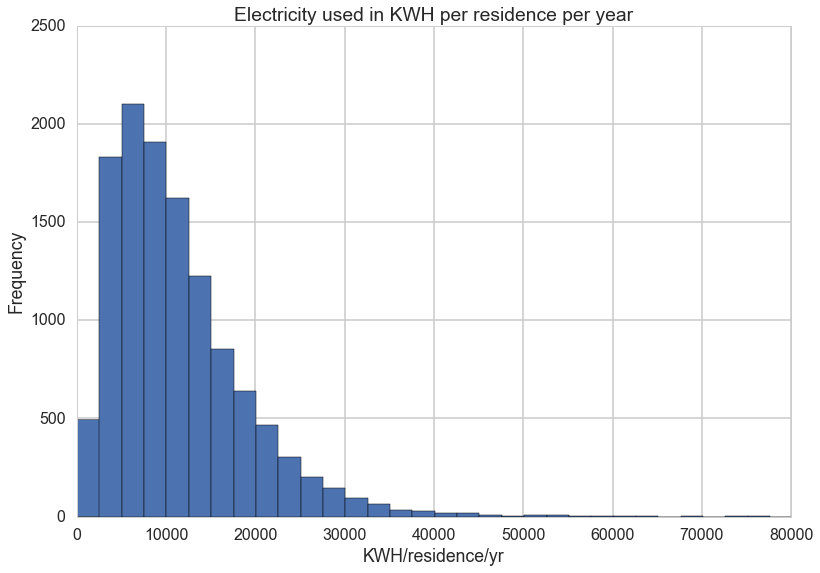

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

In [7]:
#Examine the kwh of data
plt.hist(kwh, bins=60)
plt.title("Electricity used in KWH per residence per year")
plt.xlabel("KWH/residence/yr")
plt.ylabel("Frequency")
plt.xlim([0,80000])
plt.show()

# Examine descriptive statistics
kwh.describe()

A common sense approach to approximating how much electricity a house consumes is to look at how big it is: the larger the house, the more energy it'll use. To explore this hypothesis, the following plots electricity usage per year versus squarefootage of a house.

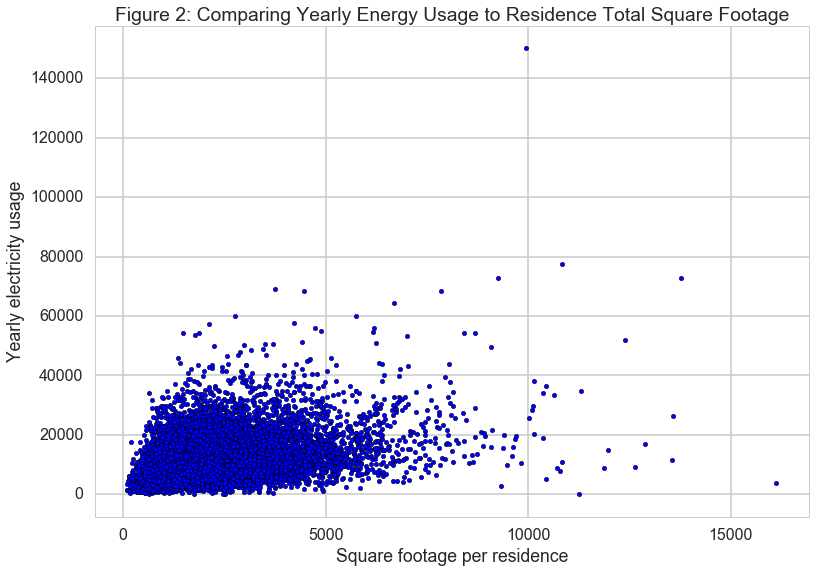

In [25]:
plt.scatter(cdata.TOTSQFT, kwh)
plt.title("Figure 2: Comparing Yearly Energy Usage to Residence Total Square Footage")
plt.xlabel("Square footage per residence")
plt.ylabel("Yearly electricity usage")
plt.autoscale(tight=True)
plt.show()

Examining figure 2 reveals that electricity usage becomes more variant as residence square footage increases. This implies that the end model will need to adjust error according to residence size. However, a linear trend will be assumed for the baseline model to which the more advanced model will be compared. 

# Modeling

For this project, a random forest regressor is used as a supervised machine learning method. A random forest is an ensemble learning method used for classification and regression tasks. The random forest is made up of many single decision trees. The random forest is appropriate for this project because it handles categorical predictors naturally and without the need for one-hot encoding which would expand the dataset beyond the processing power available for this analysis.* In addition, it can fit highly non-linear interactions and is a quick fit even for this dataset with upwards of 200 features even after initial pruning.

*http://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest

## Feature Selection
***
There is a total of 864 features in the original dataset. Due to limited processing power, an initial random forest regression will be executed on the whole dataset to simply cut out the features that have obviously no affect on the response variable 'KWH.'

### Feature Importances

In [9]:
forest=RandomForestRegressor(n_estimators=600)

In [10]:
forest.fit(cdata, kwh, sample_weight=nwgt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [11]:
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]

In [12]:
# Data frame with feature rankings
rfeats=pd.DataFrame(columns = ['no', 'imp', 'name'])

for f in range(cdata.shape[1]):
    rfeats.loc[len(rfeats)]=[indices[f], importances[indices[f]], cdata.columns[indices[f]]]

## Building Predictive Model

With a dataset that is predominantly categorical, a method that implements the use of decision trees is chosen. The advantages being that ranking of feature importance will allow for feature "pruning" and that decision trees are easily explained and visualized. An ensemble method using scikit-learn's RandomForestRegressor averages the results of many trees and offers robustness against overfitting. Sklearn's cross_val_predict uses cross validation to build the models for both the random forest and linear models.

In [17]:
cv_method = KFold(n_splits = 10, shuffle = True, random_state = 0)
RMSE = pd.DataFrame(columns = ['rmse'])
b = 21 #maximum features in a regression analysis
a = linspace(1,b,b)
for i in a:
    top_feat = rfeats[:int(i)]
    X = cdata.filter(items = top_feat.name)
    predict=cross_val_predict(forest, X, kwh, cv=cv_method)
    
    # Examine RMSE for fitted data
    rmse = (mean_squared_error(kwh, predict, nwgt))**0.5
    
    RMSE.loc[len(RMSE)] = [rmse]

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0


The following will mathematically determine the number of features to be used for modeling. Root mean square error is the error metric of choice in this project and the features will be chosen such that RMSE has reached a "steady state." To determine this, the variance of RMSE of each added feature iteration calculated above is calculated. The point at which the collective variance begins to decrease will determine the number of features to be used.

In [232]:
VAR = pd.DataFrame(columns = ['vari'])
j=2
for rm in RMSE.rmse:
    vari=np.var(RMSE.rmse[:j])
    j+=1
    VAR.loc[len(VAR)] = vari
    
feat_num = VAR.vari.idxmax()+1
print('The optimal number of features is %i' %feat_num)

The optimal number of features is 17


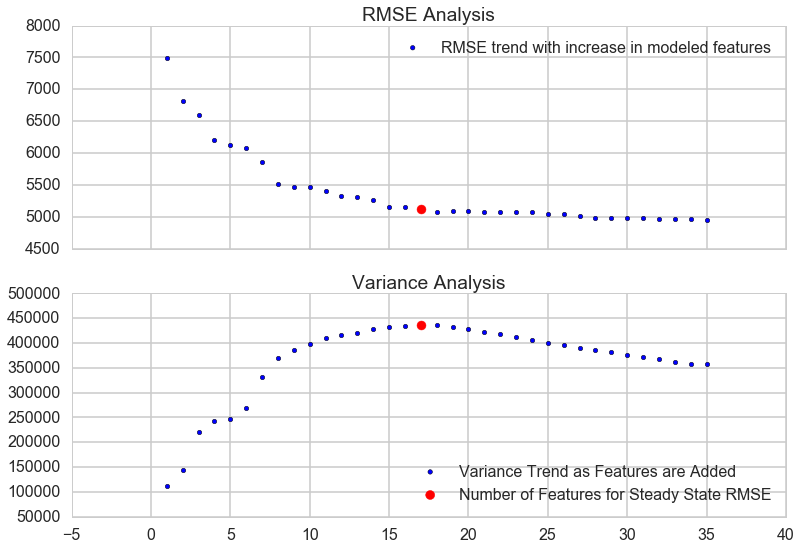

In [272]:
# Plot known values versus predicted values of linear regression and RF model
f, axarr=plt.subplots(2, sharex = True)

axarr[0].scatter(a, RMSE.rmse, label = 'RMSE trend with increase in modeled features')
axarr[0].scatter(feat_num,RMSE.rmse.loc[feat_num-1], color='red', s=80)
axarr[0].set_title('RMSE Analysis')
axarr[0].legend(loc='upper right')

axarr[1].scatter(a,VAR.vari, label='Variance Trend as Features are Added')
axarr[1].scatter(feat_num,VAR.vari.max(), color='red', s=80, label='Number of Features for Steady State RMSE')
axarr[1].set_title('Variance Analysis')
axarr[1].legend(loc='lower right')

## Model Evaulation

To evaluate the model, two simple linear models are compared.

In [283]:
# Build univariate linear model
lm = LinearRegression()
sqft=cdata.TOTSQFT.reshape(len(cdata.TOTSQFT), 1)
kwh_predict_baseline=cross_val_predict(lm, sqft, kwh, cv=cv_method)

# Examine RMSE for fitted data
rmse_baseline = (mean_squared_error(kwh, kwh_predict_baseline, nwgt))**0.5

In [284]:
# Build Intermediate (multivariate) linear model
contdata=pd.DataFrame()
for varname in cont['Variable Name']:
    contdata[varname]=data[varname]
kwh_predict_intermed=cross_val_predict(lm, contdata, kwh, cv=cv_method)

# Examine RMSE for fitted data
rmse_intermed = (mean_squared_error(kwh, kwh_predict_intermed, nwgt))**0.5

In [252]:
# Rebuild Random Forest with Optimal Number of Features
final_feat=rfeats[:feat_num-1]
X_f=cdata.filter(items = final_feat.name)
predict_f=cross_val_predict(forest, X_f, kwh, cv=cv_method)

# Examine RMSE for fitted data
rmse_f = (mean_squared_error(kwh, predict_f, nwgt))**0.5

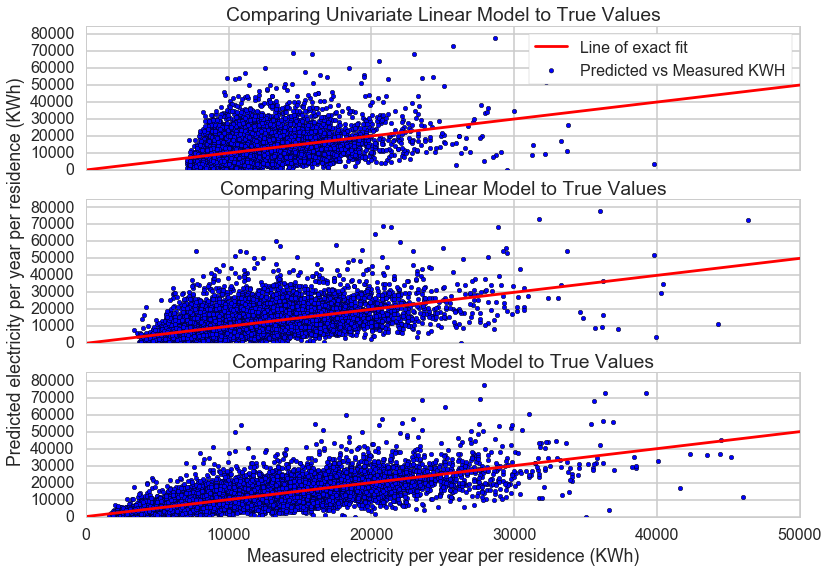

In [311]:
# Plot known values versus predicted values of linear regression and RF model
f, axarr=plt.subplots(3, sharex = True, sharey=True)
x_lim=[0, 50000]
y_lim=[0, 85000]

axarr[0].scatter(kwh_predict_baseline, kwh, label='Predicted vs Measured KWH')
axarr[0].plot(y_lim, y_lim, color='red', label = 'Line of exact fit')
axarr[0].set_title('Comparing Univariate Linear Model to True Values')
axarr[0].set_xlim(x_lim)
axarr[0].set_ylim(y_lim)
axarr[0].legend(loc='upper right', frameon = True)

axarr[1].scatter(kwh_predict_intermed, kwh, label = 'Multivariate Model Prediction vs Measured KWH')
axarr[1].set_title('Comparing Multivariate Linear Model to True Values')
axarr[1].plot(y_lim, y_lim, color='red', label = 'Line of exact fit')
axarr[1].set_ylabel('Predicted electricity per year per residence (KWh)')

axarr[2].scatter(predict_f, kwh, label = 'Random Forest Model Prediction vs Measured KWH')
axarr[2].set_title('Comparing Random Forest Model to True Values')
axarr[2].plot(y_lim, y_lim, color='red', label = 'Line of exact fit')
axarr[2].set_xlabel('Measured electricity per year per residence (kWh)')

(-50000, 50000)

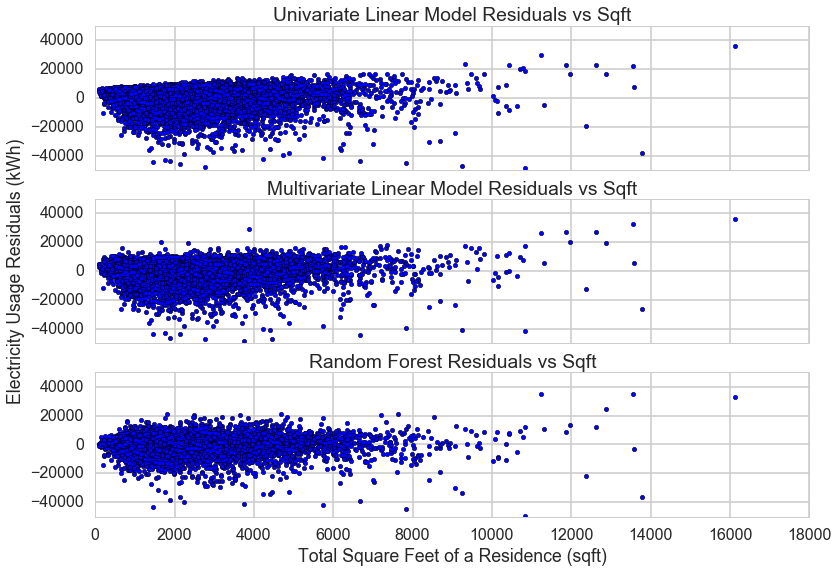

In [326]:
# Plot residuals of models
f, axarr = plt.subplots(3, sharex = True, sharey = True)

axarr[0].scatter(cdata.TOTSQFT, kwh_predict_baseline-kwh)
axarr[0].set_title('Univariate Linear Model Residuals vs Sqft')
axarr[0].set_xlim([0, 18000])
axarr[0].set_ylim([-50000, 50000])

axarr[1].scatter(cdata.TOTSQFT, kwh_predict_intermed-kwh)
axarr[1].set_title('Multivariate Linear Model Residuals vs Sqft')
axarr[1].set_ylabel('Electricity Usage Residuals (kWh)')
axarr[1].set_xlim([0, 18000])
axarr[1].set_ylim([-50000, 50000])

axarr[2].scatter(cdata.TOTSQFT, predict_f-kwh)
axarr[2].set_title('Random Forest Residuals vs Sqft')
axarr[2].set_xlabel('Total Square Feet of a Residence (sqft)')
axarr[2].set_xlim([0, 18000])
axarr[2].set_ylim([-50000, 50000])

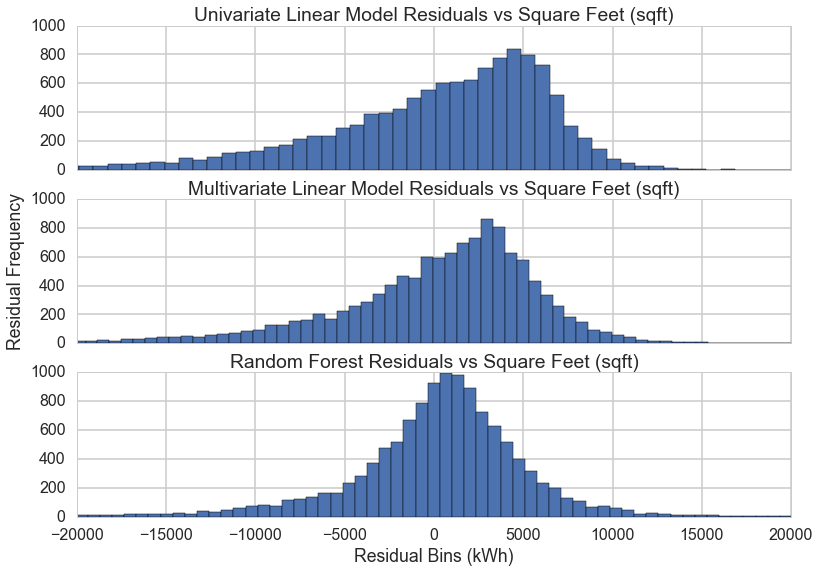

In [332]:
# Plot histogram of residuals of models
f, axarr = plt.subplots(3, sharex = True, sharey = True)

bins=200

axarr[0].hist(kwh_predict_baseline-kwh, bins=bins)
axarr[0].set_title('Univariate Linear Model Residuals vs Square Feet (sqft)')
axarr[0].set_xlim([-20000, 20000])

axarr[1].hist(kwh_predict_intermed-kwh, bins=bins)
axarr[1].set_title('Multivariate Linear Model Residuals vs Square Feet (sqft)')
axarr[1].set_ylabel('Residual Frequency')

axarr[2].hist(predict_f-kwh, bins=bins)
axarr[2].set_title('Random Forest Residuals vs Square Feet (sqft)')
axarr[2].set_xlabel('Residual Bins (kWh)')

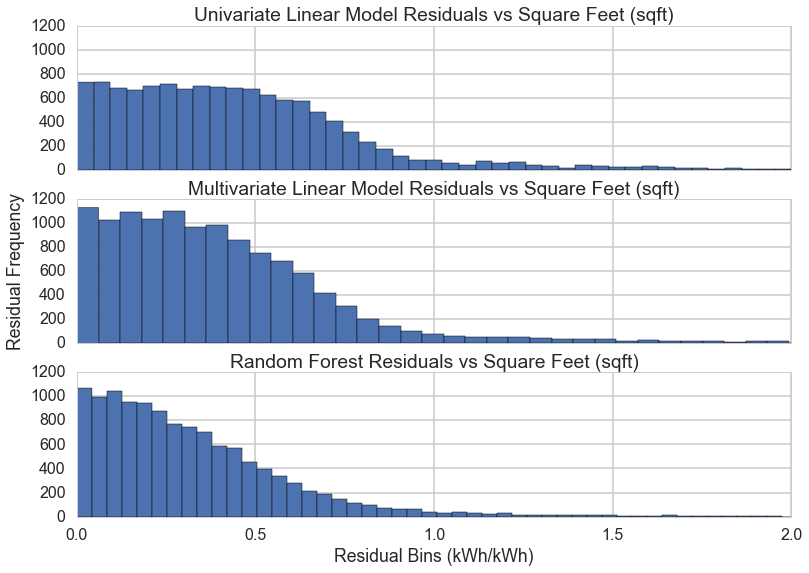

In [338]:
# Plot histogram of relative residuals of models
f, axarr = plt.subplots(3, sharex = True, sharey = True)

bins=100

axarr[0].hist(abs(kwh_predict_baseline-kwh)/kwh_predict_baseline, bins=bins)
axarr[0].set_title('Univariate Linear Model Residuals vs Square Feet (sqft)')
axarr[0].set_xlim([0,2])

axarr[1].hist(abs(kwh_predict_intermed-kwh)/kwh_predict_intermed, bins=bins)
axarr[1].set_title('Multivariate Linear Model Residuals vs Square Feet (sqft)')
axarr[1].set_ylabel('Residual Frequency')

axarr[2].hist(abs(predict_f-kwh)/predict_f, bins=bins)
axarr[2].set_title('Random Forest Residuals vs Square Feet (sqft)')
axarr[2].set_xlabel('Residual Bins (kWh/kWh)')

# Error Bars

In [393]:
def pred_ints(model, X, percentile):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X.loc[x]))
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [379]:
forest.fit(X_f, kwh, sample_weight=nwgt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [391]:
X_f.loc[0]

TOTCSQFT        3958
FUELHEAT           5
BEDROOMS           4
AGEHHMEMCAT2       8
ACROOMS            9
TOTROOMS           9
PGASHTWA          -2
CDD30YR         1271
AGEHHMEMCAT3       1
TOTHSQFT        3958
AGECDRYER          1
SWIMPOOL           0
POOL              -2
Name: 0, dtype: int64

In [ ]:
err_down, err_up = pred_ints(forest, X_f, percentile=95)

/Users/appledelete/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/appledelete/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/appledelete/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it cont

## Discussion

In [376]:
wat = array([1,2,3])

In [377]:
wat[1]

2

In [ ]:
# Weighted average, 